In [1]:
%matplotlib inline
!CUDA_LAUNCH_BLOCKING=1
!CUDA_DEVICE_ORDER="PCI_BUS_ID"
!CUDA_VISIBLE_DEVICES='0'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.layers import Input, ZeroPadding2D,concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, UpSampling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
# import efficientnet.keras as efn
import h5py, glob
import pickle5 as pickle
import numpy as np
import itertools
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(1)

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

W1024 21:14:55.329152 140115982205056 deprecation.py:323] From <ipython-input-2-ebb74ce83619>:3: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
### CAE hyp
batch_size = 32
epochs = 500
inChannel = 3
x, y = 224, 224 # height, width
input_img = Input(shape = (x, y, inChannel))
num_class = 10

# Load Data

In [4]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [5]:
[train_images, train_labels, train_files,
 test_images, test_labels, test_files] = load_pkl('../datasets/imit_ASL_10_mDreal_224x224.pkl')
train_images = np.swapaxes(np.swapaxes(train_images, 1, 3), 1, 2)
test_images = np.swapaxes(np.swapaxes(test_images, 1, 3), 1, 2)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1539, 224, 224, 3)
(1539,)
(385, 224, 224, 3)
(385,)


In [6]:
[train_images2, train_labels2, train_files2,
 test_images2, test_labels2, test_files2] = load_pkl('../datasets/imit_ASL_10_mDsim_224x224.pkl')
train_images2 = np.swapaxes(np.swapaxes(train_images2, 1, 3), 1, 2)
test_images2 =np.swapaxes( np.swapaxes(test_images2, 1, 3), 1, 2)
train_labels2 = np.argmax(train_labels2, -1)
test_labels2 = np.argmax(test_labels2, -1)

print(train_images2.shape)
print(train_labels2.shape)
print(test_images2.shape)
print(test_labels2.shape)

(1539, 224, 224, 3)
(1539,)
(385, 224, 224, 3)
(385,)


In [7]:
def plot_fig(i, history):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['accuracy'],label='Training')
    plt.plot(range(1,epochs+1),history.history['val_accuracy'],label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
#     fig.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-acc.png')
    plt.close(fig)
    # summarize history for loss
    fig2 = plt.figure()
    plt.plot(range(1,epochs+1),history.history['loss'],label='Training')
    plt.plot(range(1,epochs+1),history.history['val_loss'],label='Validation')
    plt.legend(loc=0)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
#     fig2.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-loss.png')
    plt.close(fig2)

In [57]:
early_stop = tf.keras.callbacks.EarlyStopping(
    
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


# style transfer vgg19

In [65]:
epochs = 200
lr = 0.001
optim = Adam(lr=lr) # decay rate = 5e-06 for xethru

autoencoder = Model(input_img, decoder6(encoder6(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = optim)
    
# autoencoder_train = autoencoder.fit(train_images2, train_images, batch_size=batch_size,epochs=epochs, validation_data = (test_images2, test_images), verbose=1, callbacks = [PlotLossesCallback()])
autoencoder_train = autoencoder.fit(train_images2, train_images2, batch_size=batch_size,epochs=epochs, 
                                    validation_data = (test_images2, test_images2), verbose=1, callbacks = [early_stop])

best_loss = np.min(autoencoder_train.history['val_loss'])
MODEL_FILE = "../models/realism CAE loss_" + str(round(best_loss, 4))  + ".json" # save path
WEIGHT_FILE ="../models/realism CAE loss_" + str(round(best_loss, 4))  +".h5" # save path

model_json = autoencoder.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
# loss = autoencoder_train.history['val_accuracy'][-1]
autoencoder.save_weights(WEIGHT_FILE)
# print("Saved model & weights for with accuracy of " + str(acc))
print("Saved model & weights ", MODEL_FILE)

Epoch 1/200
49/49 [==============================] - 4s 76ms/step - loss: 0.0332 - val_loss: 0.0203
Epoch 2/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0181 - val_loss: 0.0178
Epoch 3/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0161 - val_loss: 0.0155
Epoch 4/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 5/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 6/200
49/49 [==============================] - 3s 53ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 7/200
49/49 [==============================] - 3s 53ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 8/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 9/200
49/49 [==============================] - 2s 50ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 10/200
49/49 [==============================] - 3s 53ms/step - loss: 0.0135 - val_loss: 0.0134

49/49 [==============================] - 2s 50ms/step - loss: 0.0082 - val_loss: 0.0095
Epoch 163/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0082 - val_loss: 0.0095
Epoch 164/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0082 - val_loss: 0.0095
Epoch 165/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 166/200
49/49 [==============================] - 2s 49ms/step - loss: 0.0082 - val_loss: 0.0095
Saved model & weights  ../models/realism CAE loss_0.0094.json


## Visualize Results

In [66]:
from PIL import Image as im
import random

In [67]:
pred = autoencoder.predict(test_images2)
pred.shape

(385, 224, 224, 3)

Simulated Spectrograms


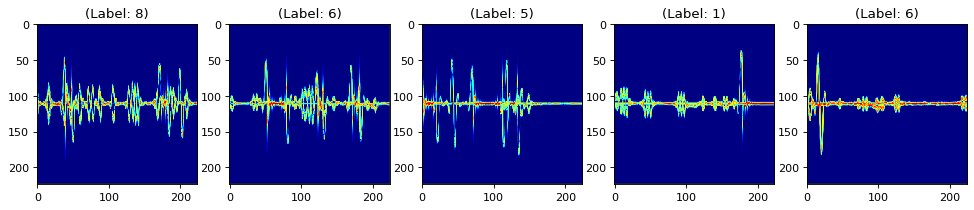

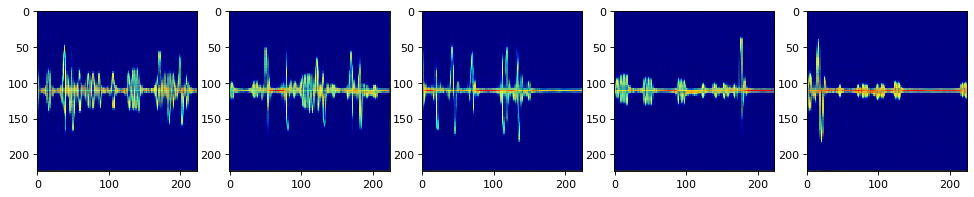

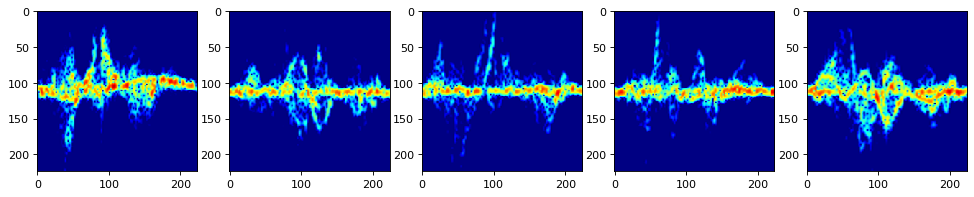

In [69]:
Y_test_label = test_labels
idx = random.randint(0, 300)
plt.figure(figsize=(15, 6), dpi=80)
print("Simulated Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(test_images2[i, ..., 1]) # , cmap='gray'=0, colored =1
    plt.imshow(test_images2[idx+i]) # , cmap='gray'=0, colored =1
#     plt.imshow(test_images2[idx+i, ..., 1]) # , cmap='gray'=0, colored =1
#     cv2.imshow('color image', test_images2[i]) # , cmap='gray'=0, colored =1
#     img = im.fromarray(test_images2[idx+i].astype(np.uint8)*255)
#     img = test_images2[i].astype(np.uint8)*255
#     plt.imshow(img) # , cmap='gray'=0, colored =1
    curr_lbl = Y_test_label[idx+i]
    plt.title("(Label: " + str(Y_test_label[curr_lbl]) + ")")
img.save('test.png')
plt.show()    
plt.figure(figsize=(15, 6), dpi=80)
# print("Realism of Test Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(pred[idx+i, ..., 1]) # , cmap='gray'  
    plt.imshow(pred[idx+i]) # , cmap='gray'  
plt.show()
plt.figure(figsize=(15, 6), dpi=80)
# print("Real Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(test_images[idx+i, ..., 1]) # , cmap='gray' 
    plt.imshow(test_images[idx+i]) # , cmap='gray'  
plt.show()

# Custom CAEs

In [33]:
# def encoderX(input_img,depth,num_filter):
#     #encoder
#     #input = 128 x 128 x 3 (wide and thin) 128x128x3
    
#     for i in range(depth):
#         conv01 = Conv2D(num_filter, (3, 3), strides=(1, 1), activation='relu', padding='same')(input_img) # 128x128x8
#         conv02 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(input_img)
#         out01  = concatenate([conv01,conv02],axis=-1)
#         pool = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
#         input_img = pool
    
#     return input_img

# def decoderX(pool,depth,num_filter):    
#     #decoder
#     for i in range(depth):
#         conv9 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(pool) # 16x16x16
#         conv10 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(pool)
#         out5  = concatenate([conv9,conv10], axis=-1)
#         up   = UpSampling2D((2,2))(out5) # 64x64x16
#         pool = up
    
#     decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(up) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    
#     return decoded

In [34]:
# depth = 3
# num_filter = 16
# autoencoder = Model(input_img, decoderX(encoderX(input_img,depth,num_filter),depth,num_filter))
# autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
# autoencoder.summary()

# Train CAE + CNN Bulk

In [35]:
# depth = [2, 3, 4]
# num_filter = [8, 16, 32]
# radars = [10,24,77]
# epochs = 100
# batch_size = 32
# acc_hist = []
# lr = 0.001
# optim = Adam(lr=lr)
# im_width = 224
# im_height = 224
# inChannel = 3
# input_img = Input(shape = (im_width, im_height, inChannel)) 
# num_class = 11

# for i in range(len(radars)):
#     radar = radars[i]
#     (X_train, Y_train, X_test, Y_test) = select_data(radar)
#     for d in range(len(depth)):
#         for f in range(len(num_filter)):
            
#             autoencoder = Model(input_img, decoderX(encoderX(input_img,depth[d],num_filter[f]),depth[d],num_filter[f]))
#             autoencoder.compile(loss='mean_squared_error', optimizer = optim, metrics=['accuracy'])

#             autoencoder_train = autoencoder.fit(X_train, X_train, validation_data = (X_test,X_test), batch_size=batch_size,epochs=epochs, verbose=0) 
            
#             model2 = Model(input_img , outputs=autoencoder.layers[4*depth[d]].output)
#             model = Sequential()

#             model.add(model2)
#             model.add(Flatten())
#             model.add(Dense(128, activation='relu'))
#             model.add(Dropout(0.5))

#             model.add(Dense(128, activation='relu'))
#             model.add(Dropout(0.5))

#             model.add(Dense(num_class))
#             model.add(Activation('softmax'))

            
#             model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
#             history = model.fit(X_train, Y_train,
#                             batch_size=batch_size,
#                             epochs=epochs,
#                             verbose=0,
#                             validation_data=(X_test, Y_test)
# #                                     callbacks = [PlotLossesCallback()]
#                                  )
#             acc = history.history['val_accuracy'][-1]
#             acc_hist.append(acc)
                    
#             MODEL_FILE = "../models/realism "+str(depth[d])+"depth "+str(num_filter[f])+"filter "+  str(num_class)+"class CAE.json" # save path
#             WEIGHT_FILE ="../models/realism "+str(depth[d])+"depth "+str(num_filter[f])+"filter "+  str(num_class)+"class CAE.h5" # save path

#             model_json = autoencoder.to_json()
#             with open(MODEL_FILE, "w") as json_file:
#                 json_file.write(model_json)
#             acc = history.history['val_accuracy'][-1]
#             acc_hist.append(acc)
#             autoencoder.save_weights(WEIGHT_FILE)
            
#             print('Parameters for '+str(radar) +' GHz: Depth = '+str(depth[d])+', Num_filter = '+str(num_filter[f])+
#                   ', Accuracy = '+str(acc))